In [1]:
import utility_common as common
import utility_commonPlot as commonp
from fit_tcmodel import *

from timeit import default_timer as timer

# 1. Load Input-Label and Model

In [2]:
baseDir = common.getBaseDirectory()
shaping = True

if shaping:
    X = np.load(baseDir + "data/templates/shaping_signalRegion/X_.npy")
    X1 = np.load(baseDir + "data/templates/shaping_controlRegion/X_.npy")
else:
    X = np.load(baseDir + "data/templates/counting_signalRegion/X_.npy")
    X1 = np.load(baseDir + "data/templates/counting_controlRegion/X_.npy")

X  = tc.from_numpy(X ).type(tc.FloatTensor ).to(device)
X1 = tc.from_numpy(X1).type(tc.FloatTensor ).to(device)   
Y  = tc.sum(X ,1).to(device) + 0.1
Y1 = tc.sum(X1,1).to(device) + 0.1


# Model and optimizer
model     = TCPredictiveModel().to(device)
optimizer = tc.optim.LBFGS( model.parameters(),
                            lr=0.002, max_iter=1e4, 
                            tolerance_grad=1e-05,
                            tolerance_change=1e-9) 

# 2. Training 

In [3]:
losses = []
# define backprop step
def closure():
    optimizer.zero_grad()
    y,regu,y1 = model.forward(X, X1)
    loss  = tc.sum( (y -Y )**2/(2*Y ) ) 
    loss += tc.sum( (y1-Y1)**2/(2*Y1) ) 
    loss += regu
    losses.append(loss)
    loss.backward(retain_graph=True) 
    return loss
# run optimization
start = timer()
optimizer.step(closure)
end = timer()
print('fitting time = {:6.4f} ms'.format( (end-start)*1000 ))

fitting time = 182276.4210 ms


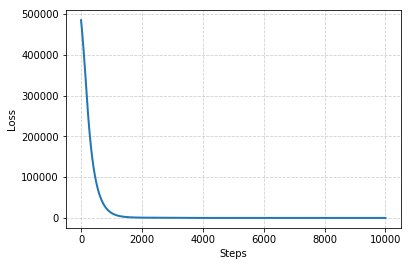

In [6]:
commonp.showLossHistory(losses[1:])
plt.savefig('../plots/fit/optimizaing')

# 3. Calculate Hessian of Loss

hessian time = 1104.7160 ms


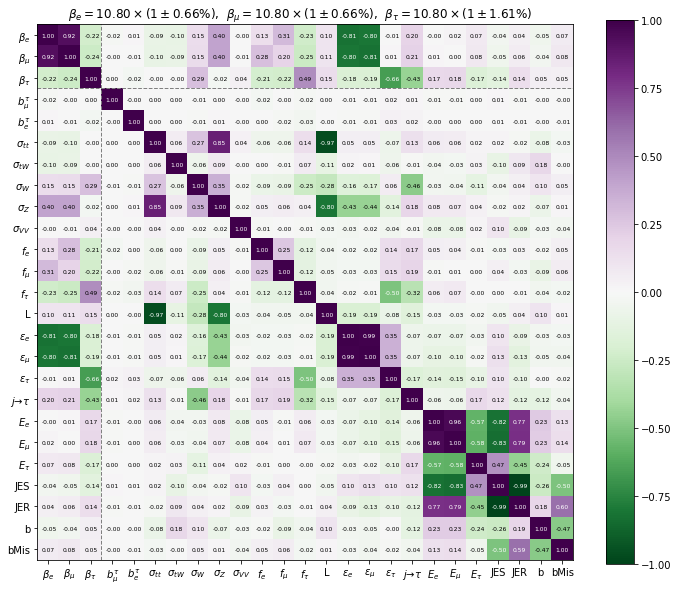

In [6]:
# forward prop X
y,regu,y1 = model.forward(X, X1)
# calculate loss and params
loss  = tc.sum( (y -Y )**2/(2*Y ) ) 
loss += tc.sum( (y1-Y1)**2/(2*Y1) ) 
loss += regu
# autograd loss w.r.t. params
start = timer()
hess = autograd2nd(loss, model)
end = timer()
print('hessian time = {:6.4f} ms'.format( (end-start)*1000 ))

hessinv = np.linalg.inv(hess)
sig = np.sqrt(hessinv.diagonal())
cor = hessinv/np.outer(sig, sig)

# show correlation and sigma
commonp.showParameterCovMat(cor,sig)

In [7]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name,param.data)
        
print(sig[0:3]/0.1080*100)
print(sig[3:])

layer_beta.params tensor([0.1082, 0.1082, 0.1086])
layer_btl.params tensor([-0.0865, -0.0843])
layer_xs.params tensor([-0.0685,  0.0372,  0.0535, -0.0683,  0.1028, -0.0291, -0.0503,  0.0176,
        -0.0456])
layer_eff.params tensor([-0.0712, -0.0840, -0.0444,  0.0164])
layer_itp.params tensor([-0.0089,  0.0467, -0.0894,  0.0921,  0.0898,  0.0017,  0.1640])
[1.44344273 1.47249531 3.86109935]
[0.99993117 0.99979779 0.61312282 0.99698283 0.93135141 0.61780789
 0.9992892  0.81090748 0.56304225 0.27251888 0.92285285 0.69110668
 0.70002845 0.88777288 0.68061664 0.6725368  0.94552435 0.94780975
 0.60067501 0.92753196 0.04620526 0.92912641]
